# High dimensional nonlinear poisson

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import time

torch.set_default_dtype(torch.float64)

In [2]:
def sample_points(N_pts, d):
    """
    Generate training samples.
    """
    # interior points
    N_domain_tot = N_pts**2
    x_int = 2 * torch.rand(N_domain_tot, d, requires_grad=True) - 1
    
    # boundary
    x_bd = np.random.normal(-1,1,size=(4*N_pts,d))
    x_bd_norm = np.linalg.norm(x_bd, axis=1, ord=np.inf) 
    x_bd = x_bd / x_bd_norm.reshape((4*N_pts,1))
    x_bd = torch.from_numpy(x_bd)
    
    return x_int, x_bd

def u_true(x):
    """
    True function.
    """
    d = x.shape[1]
    return torch.exp( -x.sum(dim=1) / d )

def f(x):
    """
    Right-hand side.
    """
    d = x.shape[1]
    
    return (-3*u_true(x)**3 + 2*u_true(x)**2) / d

def g(x):
    """
    Boundary condition.
    """
    return u_true(x)

## Models

In [3]:
class RF_PDE(nn.Module):
    """
    Random Feature model.
    """
    def __init__(self, in_features, out_features, sigma=1.0):
        super(RF_PDE, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.sigma = sigma
        self.W = nn.Parameter(torch.randn(in_features, out_features) / sigma)
        self.b = nn.Parameter(torch.rand(out_features) * 2 * torch.pi)
        
        self.model = nn.Sequential(nn.Linear(out_features, 1))

        
    def forward(self, x):
        
        u = self.model(torch.cos(x @ self.W + self.b) * torch.sqrt( torch.tensor([2 / self.out_features])))
        return u
    
    
class PINN_PDE(nn.Module):
    """
    PINN model
    """
    def __init__(self, d):
        super(PINN_PDE, self).__init__()
        self.model = nn.Sequential(
        nn.Linear(d,64),
        nn.Tanh(),
        nn.Linear(64,64),
        nn.Tanh(),
        nn.Linear(64,1))
        
    def forward(self,x):
        u = self.model(x)
        return u
    
def loss_fn(model, x_in, x_bd, RHS, g):
    """
    Compute the loss
    """
    
    # interior:
    u = model(x_in)

    u_x = torch.autograd.grad(u, x_in, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_in, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        
    f = RHS(x_in)
    f = f.reshape(u.shape)
    
    residual = (1-2*u) * torch.sum(u_x ** 2, dim=1) + (u-u**2)*torch.sum(u_xx, dim=1) - f
    
    # boundary
    u_bd = model(x_bd)
    residual_bd = model(x_bd) - g(x_bd).reshape(u_bd.shape)

    return torch.mean(residual**2) + torch.Tensor([1e6]) * torch.mean(residual_bd**2)

def train(model, optimizer, x_in, x_bd, RHS, g, epochs=1000):
    
    losses = []
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        loss = loss_fn(model, x_in, x_bd, RHS, g)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    return losses

# Decay rate --  number of collocation points

In [19]:
def decay_rate_m(d):
    
    # number of collocation points
    Points = [10,20,30]
    
    # generate test points
    N_test = 100
    x_test_int, x_test_bd = sample_points(N_test, d)
    u_test_int = u_true(x_test_int).detach().numpy()
    u_test_bd = u_true(x_test_bd).detach().numpy()
    
    # empty spaces for test errors
    T = 10
    RF_test_errors = np.zeros((len(Points), T)) 
    
    # number of random features 
    N = 100
    
    epochs = [1000,1000,1500]
    
    for i in range(len(Points)):
    
        # generate training points
        N_pts = Points[i]
        x_int_train, x_bd_train = sample_points(N_pts,d)
    
        for j in range(T):
        
            # generate RF model
            model_RF = RF_PDE(d, N, sigma = 1)
            optimizer = optim.Adam(model_RF.parameters(), lr=1e-2, weight_decay=0.000001)
            # train the model
            losses = train(model_RF, optimizer, x_int_train, x_bd_train, f, g, epochs=epochs[i])
    
            # compute test errors
            RF_pred_int = model_RF(x_test_int).detach().numpy()
            RF_pred_bd = model_RF(x_test_bd).detach().numpy()
        
            err_int = np.sum( (u_test_int.reshape(RF_pred_int.shape) - RF_pred_int ) ** 2 )
            err_bd = np.sum( (u_test_bd.reshape(RF_pred_bd.shape) - RF_pred_bd) ** 2 )
            err_RF = (err_int + err_bd) / (np.size(RF_pred_int) + np.size(RF_pred_bd) )
            RF_test_errors[i,j] = err_RF
        
    return np.mean(RF_test_errors,axis=1)

In [23]:
RF_test_errors_d4 = decay_rate_m(4)
RF_test_errors_d6 = decay_rate_m(6)
RF_test_errors_d8 = decay_rate_m(8)

Epoch 0, Loss: 2624062.0502031026
Epoch 0, Loss: 2694709.5746232094
Epoch 0, Loss: 2355132.908604297
Epoch 0, Loss: 2829342.2934749844
Epoch 0, Loss: 3087281.332176982
Epoch 0, Loss: 2952801.769770302
Epoch 0, Loss: 3317036.2110379627
Epoch 1000, Loss: 129.93590674008982
Epoch 0, Loss: 2867209.3437458533
Epoch 1000, Loss: 145.92462190054118
Epoch 0, Loss: 2677294.8741905685
Epoch 1000, Loss: 122.54393923395298
Epoch 0, Loss: 2226921.0062234853
Epoch 0, Loss: 2407124.1891780784
Epoch 0, Loss: 2153098.809950969
Epoch 0, Loss: 2909492.203726181
Epoch 0, Loss: 2683361.8695324436
Epoch 0, Loss: 2560475.937214266
Epoch 0, Loss: 2703261.7402215134
Epoch 1000, Loss: 106.66266195800891
Epoch 0, Loss: 2598931.5240527475
Epoch 1000, Loss: 83.28964863945149
Epoch 0, Loss: 2495012.375805792
Epoch 1000, Loss: 80.97400937652122
Epoch 0, Loss: 2284879.0823736284
Epoch 0, Loss: 2374441.5570493354
Epoch 0, Loss: 2269790.7023711395
Epoch 0, Loss: 2021207.1106597667
Epoch 0, Loss: 2469076.6831282484
Epoch

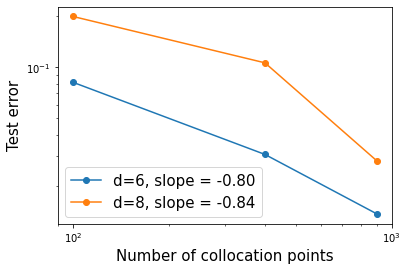

In [25]:
Points = [10,20,30]

# compute slopes
k4 = np.polyfit(np.log(Points), np.log(RF_test_errors_d4), 1)[0]/2
k6 = np.polyfit(np.log(Points), np.log(RF_test_errors_d6), 1)[0]/2
k8 = np.polyfit(np.log(Points), np.log(RF_test_errors_d8), 1)[0]/2

# visualization
#plt.loglog(np.power(Points,2), RF_test_errors_d4, '-o', label=f'd=4, slope = {k4:.2f}')
plt.loglog(np.power(Points,2), RF_test_errors_d6, '-o', label=f'd=6, slope = {k6:.2f}')
plt.loglog(np.power(Points,2), RF_test_errors_d8, '-o', label=f'd=8, slope = {k8:.2f}')
plt.legend(fontsize=15)
plt.xlabel('Number of collocation points', size=15)
plt.ylabel('Test error', size=15)
plt.savefig('Poisson_rate_m.pdf', bbox_inches = 'tight')

# Decay rate -- number of random features

In [10]:
def decay_rate_N(d, epochs):
    
    # number of collocation points
    N_pts = 20
    x_int_train, x_bd_train = sample_points(N_pts,d)
    
    # generate test points
    N_test = 100
    x_test_int, x_test_bd = sample_points(N_test, d)
    u_test_int = u_true(x_test_int).detach().numpy()
    u_test_bd = u_true(x_test_bd).detach().numpy()
    
    # number of random features
    N_range = [100, 400]
    
    T = 10
    RF_test_errors = np.zeros((len(N_range),T))
    
    for i in range(len(N_range)):
        
        # number of features
        N = N_range[i]
        
        for j in range(T):
            
            # generate RF model
            model_RF = RF_PDE(d, N, sigma = 3)
            optimizer = optim.Adam(model_RF.parameters(), lr=1e-2, weight_decay=0.000001)
            # train the model
            losses = train(model_RF, optimizer, x_int_train, x_bd_train, f, g, epochs=epochs[i])
    
            # compute test errors
            RF_pred_int = model_RF(x_test_int).detach().numpy()
            RF_pred_bd = model_RF(x_test_bd).detach().numpy()

            err_int = np.sum( (u_test_int.reshape(RF_pred_int.shape) - RF_pred_int ) ** 2 )
            err_bd = np.sum( (u_test_bd.reshape(RF_pred_bd.shape) - RF_pred_bd) ** 2 )
            err_RF = (err_int + err_bd) / (np.size(RF_pred_int) + np.size(RF_pred_bd) )
            RF_test_errors[i,j] = err_RF
            
    return np.mean(RF_test_errors, axis=1)   

In [11]:
RF_err_N6 = decay_rate_N(6, epochs = [600,1200])
RF_err_N8 = decay_rate_N(8, epochs = [800,1500])

Epoch 0, Loss: 2292070.437997964
Epoch 0, Loss: 2102802.6529859714
Epoch 0, Loss: 2612015.688056337
Epoch 0, Loss: 2257092.041879887
Epoch 1000, Loss: 173.2743975303811
Epoch 0, Loss: 2585464.10656915
Epoch 1000, Loss: 164.01962745848812
Epoch 0, Loss: 2585300.783387204
Epoch 1000, Loss: 191.95256511035478
Epoch 0, Loss: 2578075.112193892
Epoch 0, Loss: 3216792.4144325373
Epoch 0, Loss: 2731535.3612961285
Epoch 0, Loss: 2299181.8401947827
Epoch 1000, Loss: 95.12311451757157
Epoch 0, Loss: 2388827.51135373
Epoch 1000, Loss: 99.65076757150374
Epoch 0, Loss: 2510948.5638929424
Epoch 1000, Loss: 104.81807502903027


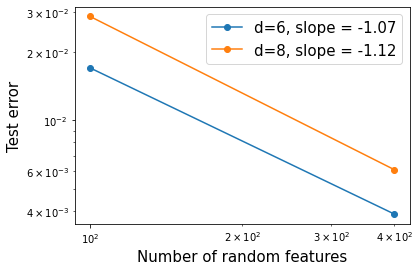

In [13]:
# compute slopes
N_range = [100, 400]
kN6 = np.polyfit(np.log(N_range), np.log(RF_err_N6), 1)[0]
kN8 = np.polyfit(np.log(N_range), np.log(RF_err_N8), 1)[0]

# visualization
plt.loglog(N_range, RF_err_N6, '-o', label=f'd=6, slope = {kN6:.2f}')
plt.loglog(N_range, RF_err_N8, '-o', label=f'd=8, slope = {kN8:.2f}')
plt.legend(fontsize=15)
plt.xlabel('Number of random features', size=15)
plt.ylabel('Test error', size=15)
plt.savefig('Poisson_rate_N.pdf', bbox_inches = 'tight')